INFO:fer:30.00 fps, 154 frames, 5.13 seconds
INFO:fer:Making directories at output
INFO:fer:Deleted pre-existing output\one_to_one_Trim5_output.mp4
100%|████████████████████████████████████████████████████████████████████████████| 154/154 [00:57<00:00,  2.70frames/s]
INFO:fer:Completed analysis: saved to output\one_to_one_Trim5_output.mp4
INFO:fer:Starting to Zip
INFO:fer:Compressing: 32%
INFO:fer:Compressing: 64%
INFO:fer:Compressing: 97%
INFO:fer:Zip has finished


23.569999999999997
0.0
18.119999999999997
29.599999999999994
29.35
0.6000000000000003
52.69000000000001
0.08533333333333333


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Wav2Vec2CTCTokenizer'. 
The class this function is called from is 'Wav2Vec2Tokenizer'.
C:\ProgramData\Anaconda3\lib\site-packages\transformers\models\wav2vec2\tokenization_wav2vec2.py:746: FutureWarning: The class `Wav2Vec2Tokenizer` is deprecated and will be removed in version 5 of Transformers. Please use `Wav2Vec2Processor` or `Wav2Vec2CTCTokenizer` instead.
  warnings.warn(
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


HELLO HELLO


ValueError: Input signal length=0 is too small to resample from 48000->16000

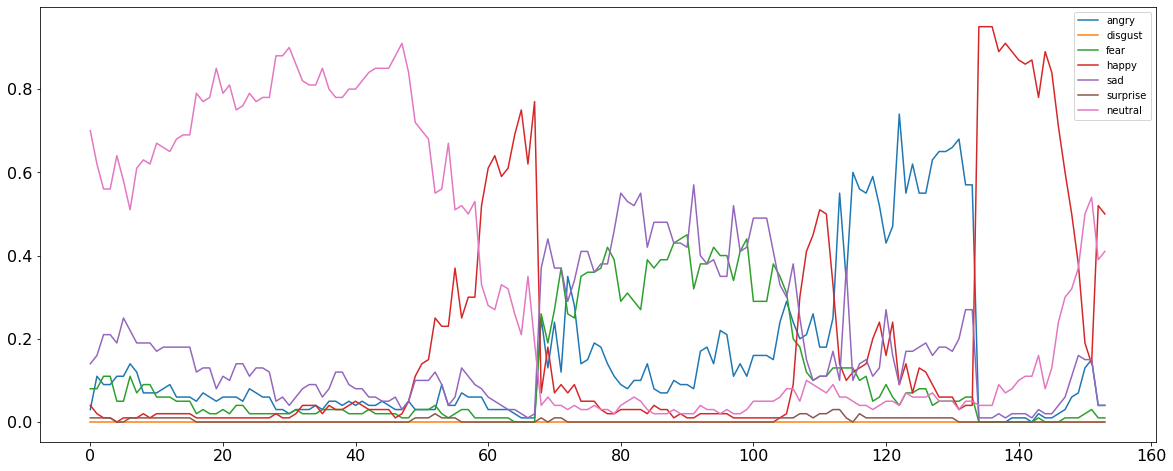

In [16]:
from fer import FER
import matplotlib.pyplot as plt 
from fer import Video
from fer import FER
import os
import sys
import pandas as pd
import torch
from pydub import AudioSegment
import librosa
import torch
from transformers import Wav2Vec2ForCTC, Wav2Vec2Tokenizer
from pydub import AudioSegment
from pydub import AudioSegment as am
# Put in the location of the video file that has to be processed
location_videofile = "C:/Users/Razai/one_to_one_Trim5.mp4"


# Build the Face detection detector
face_detector = FER(mtcnn=True)
# Input the video for processing
input_video = Video(location_videofile)

# The Analyze() function will run analysis on every frame of the input video. 
# It will create a rectangular box around every image and show the emotion values next to that.
# Finally, the method will publish a new video that will have a box around the face of the human with live emotion values.
processing_data = input_video.analyze(face_detector, display=False)

# We will now convert the analysed information into a dataframe.
# This will help us import the data as a .CSV file to perform analysis over it later
vid_df = input_video.to_pandas(processing_data)
vid_df = input_video.get_first_face(vid_df)
vid_df = input_video.get_emotions(vid_df)

# Plotting the emotions against time in the video
pltfig = vid_df.plot(figsize=(20, 8), fontsize=16).get_figure()

# We will now work on the dataframe to extract which emotion was prominent in the video
angry = sum(vid_df.angry)
disgust = sum(vid_df.disgust)
fear = sum(vid_df.fear)
happy = sum(vid_df.happy)
sad = sum(vid_df.sad)
surprise = sum(vid_df.surprise)
neutral = sum(vid_df.neutral)

print(angry)
print(disgust)
print(fear)
print(happy)
print(sad)
print(surprise)
print(neutral)

emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
emotions_values = [angry, disgust, fear, happy, sad, surprise, neutral]

score_comparisons = pd.DataFrame(emotions, columns = ['Human Emotions'])
score_comparisons['Emotion Value from the Video'] = emotions_values


mp4_file = location_videofile
wav_filename = "textnew16hz1.wav"
track = AudioSegment.from_file(mp4_file,  format= 'mp4')
file_handle = track.export(wav_filename, format='wav')

sound = AudioSegment.from_file(wav_filename, format='wav', frame_rate=48000)
sound = sound.set_frame_rate(16000)
sound.export("C:/Users/Razai/new16hz1.wav", format='wav')

sound_new = AudioSegment.from_file(wav_filename, format="wav")

#new_mp3_audio= mp3_audio + 10 # increase volume of audio


print(len(sound_new)/(1000*60))

# 12 Minutes audio breaks into 3 minutes 4 audio files (slicing is done by milliseconds)

counter_audio = 180
split_audio = [sound_new[:180*1000]]
for i in range(4):
    split_audio.append(sound_new[counter_audio*1000:(counter_audio+180)*1000])
    counter_audio += 180

count = 0
# # lets save it!
for count, audio_object in enumerate(split_audio):
    count += 1
    with open(f"{count}_wav_filename", 'wb') as out_f:
        audio_object.export(out_f, format='wav')
        
tokenizer = Wav2Vec2Tokenizer.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")
collection_of_text = []
for i in range(4):

    speech, rate = librosa.load(f"{i+1}_wav_filename", sr=16000)

    input_values = tokenizer(speech, return_tensors='pt').input_values
    # Store logits (non-normalized predictions)
    with torch.no_grad():
        logits = model(input_values).logits

    # Store predicted id's
    predicted_ids = torch.argmax(logits, dim=-1)
    # decode the audio to generate text
    # Passing the prediction to the tokenzer decode to get the transcription
    transcription = tokenizer.batch_decode(predicted_ids)[0]
    # transcriptions = tokenizer.decode(predicted_ids[0])
    print(transcription)
    collection_of_text.append(transcription)

print(collection_of_text)
final_complete_speech = ""

# convert batch of text into one complete sentence
for i in collection_of_text:
    final_complete_speech += i
asad
print(final_complete_speech)

output_file = open('emotion_value.txt', 'w')
for emotion in emotions_values :
    output_file.write(f'{emotion}\n')
output_file.close()